<a href="https://colab.research.google.com/github/fellowship/touch-up-the-hair/blob/main/hairoot_%20masks/Inpainting_SD_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Modules and define functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -qU mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [3]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from transformers import AutoProcessor, CLIPSegForImageSegmentation
import mediapipe as mp
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter
from typing import Tuple



In [4]:
def apply_colormap(mask: torch.Tensor, colormap) -> np.ndarray:
    """Apply a colormap to a tensor and convert it to a numpy array."""
    colored_mask = colormap(mask.numpy())[:, :, :3]
    return (colored_mask * 255).astype(np.uint8)

def resize_image(image: np.ndarray, dimensions: Tuple[int, int]) -> np.ndarray:
    """Resize an image to the given dimensions using linear interpolation."""
    return cv2.resize(image, dimensions, interpolation=cv2.INTER_LINEAR)

def overlay_image(background: np.ndarray, foreground: np.ndarray, alpha: float) -> np.ndarray:
    """Overlay the foreground image onto the background with a given opacity (alpha)."""
    return cv2.addWeighted(background, 1 - alpha, foreground, alpha, 0)

def dilate_mask(mask: torch.Tensor, dilation_factor: float) -> torch.Tensor:
    """Dilate a mask using a square kernel with a given dilation factor."""
    kernel_size = int(dilation_factor * 2) + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_dilated = cv2.dilate(mask.numpy(), kernel, iterations=1)
    return torch.from_numpy(mask_dilated)

def segment_image(image: Image.Image, text: str, blur: float, threshold: float, dilation_factor: int) -> np.ndarray:
        """Create a segmentation mask from an image and a text prompt using CLIPSeg.

        Args:
            image (Image.Image): The image to segment.
            text (str): The text prompt to use for segmentation.
            blur (float): How much to blur the segmentation mask.
            threshold (float): The threshold to use for binarizing the segmentation mask.
            dilation_factor (int): How much to dilate the segmentation mask.

        """
        processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
        model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

        input_prc = processor(text=text, images=image, padding="max_length", return_tensors="pt")

        # Predict the segemntation mask
        with torch.no_grad():
            outputs = model(**input_prc)

        tensor = torch.sigmoid(outputs[0]) # get the mask

        # Apply a threshold to the original tensor to cut off low values
        thresh = threshold
        tensor_thresholded = torch.where(tensor > thresh, tensor, torch.tensor(0, dtype=torch.float))

        # Apply Gaussian blur to the thresholded tensor
        sigma = blur
        tensor_smoothed = gaussian_filter(tensor_thresholded.numpy(), sigma=sigma)
        tensor_smoothed = torch.from_numpy(tensor_smoothed)

        # Normalize the smoothed tensor to [0, 1]
        mask_normalized = (tensor_smoothed - tensor_smoothed.min()) / (tensor_smoothed.max() - tensor_smoothed.min())

        # Dilate the normalized mask
        mask_dilated = dilate_mask(mask_normalized, dilation_factor)

        # Convert the mask to a heatmap and a binary mask
        heatmap = apply_colormap(mask_dilated, cm.viridis)
        binary_mask = apply_colormap(mask_dilated, cm.Greys_r)

        image_np = np.array(image)
        # Overlay the heatmap and binary mask on the original image
        dimensions = (image_np.shape[1], image_np.shape[0])
        heatmap_resized = resize_image(heatmap, dimensions)
        binary_mask_resized = resize_image(binary_mask, dimensions)

        alpha_heatmap, alpha_binary = 0.5, 1
        overlay_heatmap = overlay_image(image_np, heatmap_resized, alpha_heatmap)
        overlay_binary = overlay_image(image_np, binary_mask_resized, alpha_binary)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(overlay_heatmap)
        axes[0].axis('off')  # Hide axis
        axes[1].imshow(overlay_binary)
        axes[1].axis('off')  # Hide axis

        # Show the plot
        plt.tight_layout()
        plt.show()

        return binary_mask_resized


## Get hair mask

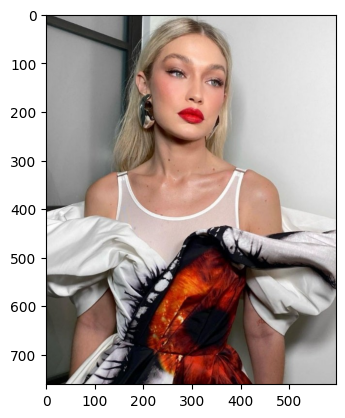

In [5]:
# Load the image using PIL (Python Imaging Library)
image_dir='/content/drive/MyDrive/Touchup_Hairroots/data/pic36.jpg' # @param {type: "string"}
init_image = Image.open(image_dir)
plt.imshow(init_image);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

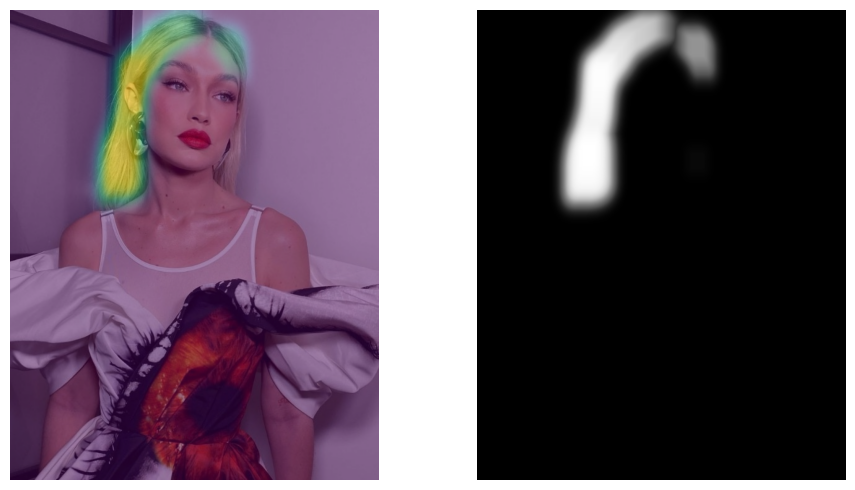

In [6]:
#@markdown Adjust the following parameters if the mask is too small or too big.
text = 'scalp' # @param {type: "string"}
blur = 6 #@param {type:'number'}
threshold = 0.5 #@param {type:'number'}
dilation_factor = 5 #@param {type:'number'}
clipseg_mask = segment_image(init_image, text, blur, threshold, dilation_factor)

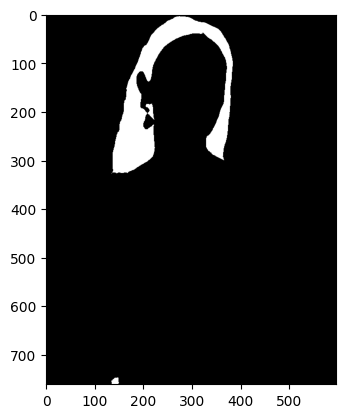

In [7]:
BaseOptions = mp.tasks.BaseOptions
ImageSegmenter = mp.tasks.vision.ImageSegmenter
ImageSegmenterOptions = mp.tasks.vision.ImageSegmenterOptions
VisionRunningMode = mp.tasks.vision.RunningMode

BG_COLOR = (0, 0, 0)  # Black RGB Color
MASK_COLOR = (255, 255, 255)  # White RGB Color
# Create a image segmenter instance with the image mode:
options = ImageSegmenterOptions(
    base_options=BaseOptions(model_asset_path='/content/drive/MyDrive/Touchup_Hairroots/selfie_multiclass_256x256.tflite'),
    running_mode=VisionRunningMode.IMAGE,
    output_category_mask=True)
with ImageSegmenter.create_from_options(options) as segmenter:
  # Load the input image from an image file.
  mp_image = mp.Image.create_from_file(image_dir)
  # Perform image segmentation on the provided single image.
  # The image segmenter must be created with the image mode.
  segmentation_result = segmenter.segment(mp_image)
  category_mask = segmentation_result.category_mask
  '''
  0 - background
  1 - hair
  2 - body-skin
  3 - face-skin
  4 - clothes
  5 - others (accessories)
  '''
  # Generate solid color images for showing the output segmentation mask.
  image_data = mp_image.numpy_view()
  fg_image = np.zeros(image_data.shape, dtype=np.uint8)
  fg_image[:] = MASK_COLOR
  bg_image = np.zeros(image_data.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR

  condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) ==3
  face_mask = np.where(condition, fg_image, bg_image)
  condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) ==1
  hair_mask = np.where(condition, fg_image, bg_image)
  plt.imshow(hair_mask)

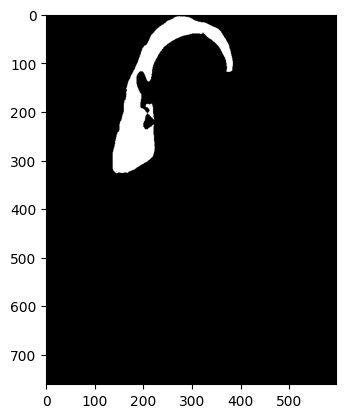

In [8]:
# Perform bitwise AND operation
mask_overlap = cv2.bitwise_and(hair_mask, clipseg_mask)
# Apply thresholding to convert non-binary mask to binary mask
_, mask_overlap_binary = cv2.threshold(mask_overlap, 0.1*255, 255, cv2.THRESH_BINARY)
# Display the masked area of the image
plt.imshow(mask_overlap_binary);

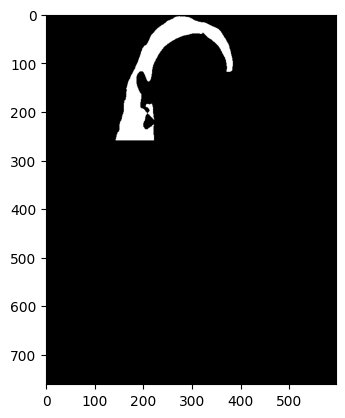

In [9]:
# Convert three-channel masks to single-channel masks
mask1_single_channel = mask_overlap_binary[..., 0]  # Extract the first channel
mask2_single_channel = face_mask[..., 0]  # Extract the first channel

# Find the maximum row index where any column has a non-zero value in both masks
row_sums1 = np.sum(mask1_single_channel, axis=1)
row_sums2 = np.sum(mask2_single_channel, axis=1)
max_row_indices_mask1 = np.where(row_sums1 > 0)[0].max()
max_row_indices_mask2 = np.where(row_sums2 > 0)[0].max()
if max_row_indices_mask1 > max_row_indices_mask2:
  # Set rows larger than the maximum row index to zero in mask1
  mask1_single_channel[max_row_indices_mask2:, :] = 0
# Convert single-channel mask back to three-channel mask
mask1_restored = np.repeat(mask1_single_channel[:, :, np.newaxis], 3, axis=2)
plt.imshow(mask1_restored)